# Tarea 3 - Parte 1.1
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumnos:
- Jose Caimapo, jose.caimapo.12@sansano.usm.cl

- Eliana Providel Godoy, eprovide@inf.utfsm.cl

In [1]:
from keras.datasets import mnist
import numpy as np
import keras

from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.layers import Reshape,Conv2DTranspose,Activation
from keras.layers import Lambda

from keras.models import Model
from keras.models import load_model
from keras import backend as K

import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

from scipy.stats import norm

import time

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

# Modelos Generativos 
** Datos de MINIST **: Digitos escritos a mano.

In [3]:
#Cargar los datos y separar en train: 60000 
def loadData():
    (_X_train, _y_train), (_X_test, _y_test) = mnist.load_data()
    _X_train = _X_train.astype('float32')
    _X_test = _X_test.astype('float32')
    #normalizando
    _X_train /= 255
    _X_test /= 255

    print(_X_train.shape[1:])
    _img_rows, _img_cols =_X_train.shape[1:]
    _channel  = 1
    return _X_train, _y_train, _X_test, _y_test, _img_rows, _img_cols , _channel

In [4]:
##Formato de X_train y X_tets
def printFormatX(_X_train, _X_test):
    print("X Train ",_X_train.shape)
    print("X Test", _X_test.shape)
    
def printFormatY(_y_train, _y_test):
    print("Y Train ",_y_train.shape)
    print("Y Test", _y_test.shape)    

##Dando la forma para entrenar, dando la dimensión deseada
def reshapeData(_X_train, _X_test):
    _X_train = np.reshape(_X_train, (len(_X_train), 28, 28,1)) 
    _X_test = np.reshape(_X_test, (len(_X_test), 28, 28,1))
    return _X_train, _X_test

In [5]:
X_train, y_train, X_test, y_test, img_rows, img_cols , channel = loadData()
printFormatX(X_train, X_test)
printFormatY(X_train, X_test)

(28, 28)
X Train  (60000, 28, 28)
X Test (10000, 28, 28)
Y Train  (60000, 28, 28)
Y Test (10000, 28, 28)


In [6]:
print("Reshape")
X_train, X_test = reshapeData(X_train, X_test)
printFormatX(X_train, X_test)

Reshape
X Train  (60000, 28, 28, 1)
X Test (10000, 28, 28, 1)


In [7]:
def plot_im(_X,n): # datos y total de datos para mostrar
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(_X[i].reshape(28, 28))
        #plt.gray()
        plt.title('original')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

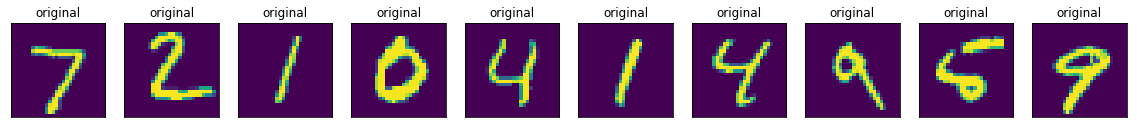

In [8]:
##Mostrando los datos de entrada
plot_im(X_test,10)

### 1.1 *Variational Autoencoder* (VAE)

#### a) Defina la sección del encoder del VAE como el que se muestra en el código, de 3 bloque convolucionales y una bloque fully conected, con una distribución Normal multivariada de 2 componentes para las variables latentes. Describa la arquitectura utilizada para el encoder.

In [9]:
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128

## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

** Arquitectura Encoder:** Input -> Conv2D*3 -> Flatten -> Dense

* Esta compuesta por tres capas convoluciones, que reciben el número de filtros, el tamaño del kernel, el tipos de padding (donde same indica que al dezplazar el kernel se podrá salir de la imagen) y función de activación relu. Para el caso de la tercera capa convolucional, recibe otro parametro que es el strides, que indica el número de pixeles que avanza la ventana/kernel en cada cálculo que lo permite que diminiya la dimensionalidad de la imagen y asu vez la cantidad de parámetros. También se aumenta el tamaño del kernel.
* Luego deja todo el un vector undimensional (flatten)
* Finalmente estan las capas densas, donde se tiene la representación codificada de la entrada, y parámetros de la distribución latente. Especificamente, los datos de entrada x se convierten  en dos parámetros del espacio latente media y (log)varianza: z_mean y z_log_var, que serviran para mas adelante poder muestrear aleatoriamente puntos similares a z de la disttribución latente.

#### b)Defina la sección del decoder del VAE como el que se muestra en el código, una tanda fully conected y con 3 bloque de la operación inversa a una convolución (Convolución transpuesta [2]), comente cómo ésta trabaja y los parámetros de stride como funcionan. Además se setea la distribución de las variables latentes como una distribución Normal multivariada de 2 componentes. 

In [10]:
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

** Decoder** Dense->Reshape->Cons2DTranspose*3

* El decoder es basicamente en encoder inverso.
* En la primera línea, necesita conocer la forma del enconder (shape_before_flattening = K.int_shape(conv_3)[1:])
* Luego estan las capas densas, y el reshape, para volver al formato original, luego de que encoder se dejara en una dimensión.
* Dado que el encoder, nos entrega una representación comprimida de la imagen, es necesario volver al tamaño original, y es ahí donde de utiliza la operación inversa de la convolución o Deconvolution, con los mismos parámetros que en la convolución, sólo que ahora de forma inversa.
* La convolución transpuesta  busca hacer upsampling o recontrucción de una imagen, tomando como entrada el resultado de la convoluviónde dicha imagen. Esto se realiza haciendo una operación de convolución pero considerando una matriz que tiene una forma equivalente a la traspuesta de la matriz de convolución original. Al decir equivalente nos referimos a que la organización repetititva de los pesos respeta las posiciones que se encontrarían en la traspuesta de la matriz original. Sin embargo los valores de los pesos no necesariamente son los mismos si no que aprendidos por la red neuronal. En general el dato de entrada tendrá menor dimensión que el dato de salida, entonces para cada pixel del dato de entrada la convolución traspuesta genera una región de pixeles en la imagen reconstruída. La posición de cada región de pixeles esta determinada por la posición de cada pixel en el dato de entrada, considerando las propiedades geométricas o de localización propias de la operación de convolución. Cada una de estas regiones debe ser rellenada con valores que no existen en la matriz de entrada. Algunas políticas son rellenar con cero o repetir el mismo valor, o realizar una poderación. 
* El parámetro de stride indica la proporción entre el movimiento en la salida y en la entrada. A mayor stride existe menor solapamiento en las regiones que se van generando y viceversa.


* Como se menciono anteriormente padding=same se podrá salir de la imagen codificada, buscando obtener un relleno tal que la dimensión de salida no sufra cambios. Para este caso ira avanzazo de dos pixeles (strides = 2).

#### c) Defina la sección que conecta a estas dos partes a través de un *sampleo* implicito ($g = \mu_{z^{(i)}} + \sigma_{z^{(i)}}\cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilistico/bayesiano. Describa el modelo completo.

In [11]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

** Modelo completo **
* Dado que ya se tiene definido el encode y el autoencoder, es necesario conectar los dos modelo, mediante z_mean y z_log_var
* Como se menciono anteriormente, se desea poder obtener valores similares del espacio latente mediante z = z_mean + exp(z_log_var) * epsilon. Para luego asignar estos valores latentes a la entradas de reconstrucción, pasando por cada una de las capas del decoder. Lo que se obtiene de la última capa del decoder, es lo que se instancia del modelo vae para obtener la imagen original.
* Como se observa el resumen, el modelo esta compuesto finalmente  por:

Input -> Conv2D x 3 -> Flatten -> Dense -> (z_mean, z_var_log) ~ z -Dense->Reshape->Cons2DTranspose x 3


In [12]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

#### d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.

In [13]:
# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

** Comentarios **
* La función de perdida entregará entregará el erroe entre los datos decodificado de la distribución latente y los datos originales.
* Se elige binary_crossentropy. A pesar de que se se trabaja con la imagen sin peder su dimensionalidad, los valores que representan cada información de la imagen se dejaron en rango $[0,1]^d$.
* KL Divergence podría funcionar como regularizador  dado que permite obtener la distancia entre la distribución latente y la original. Con esto se busca durante el entrenamiento poder reducir la diferencia entre el encoder correcto, pero inefiente, y el encoder aproximado, pero que es más eficiente. Penalizando de esta forma representaciones diferentes para números similares.

#### e) Entrene el modelo definido con los datos de MNIST entre 10 a 15 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.

In [14]:
printFormatX(X_train, X_test)

X Train  (60000, 28, 28, 1)
X Test (10000, 28, 28, 1)


In [15]:
history_dim2 = []
batch_size = 256
#epochs =  [10,15]
vae.compile(optimizer='rmsprop')
start_time = time.time()
history_dim2.append(vae.fit(X_train,epochs=10, batch_size=batch_size,validation_data=(X_test, None)))
end_time = time.time()
time_e = end_time - start_time
print("Tiempo ", time_e)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 174us/step - loss: 198.6840 - val_loss: 170.2634
Epoch 2/10
60000/60000 [==============================] - 6s 97us/step - loss: 166.3558 - val_loss: 161.1601
Epoch 3/10
60000/60000 [==============================] - 6s 96us/step - loss: 159.1386 - val_loss: 156.7540
Epoch 4/10
60000/60000 [==============================] - 6s 96us/step - loss: 155.2728 - val_loss: 152.7521
Epoch 5/10
60000/60000 [==============================] - 6s 98us/step - loss: 152.7271 - val_loss: 152.5810
Epoch 6/10
60000/60000 [==============================] - 6s 96us/step - loss: 150.8145 - val_loss: 149.2226
Epoch 7/10
60000/60000 [==============================] - 6s 98us/step - loss: 149.1200 - val_loss: 148.9112
Epoch 8/10
60000/60000 [==============================] - 6s 98us/step - loss: 147.7214 - val_loss: 148.8445
Epoch 9/10
60000/60000 [==============================] - 6s 95us/step - los

### f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_{z^{(i)}}$. Además genere un histograma de la media y la varianza $\sigma_{z^{(i)}}^2$ de las dos componentes. Comente

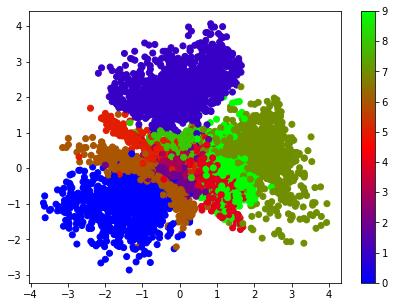

In [16]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(7, 5))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap = 'brg')
plt.colorbar()
#plt.show()
encoder_log_var = Model(x,z_log_var)

** Comentarios **
* Al realizar la predicción, utilizando el encoder, se traspasan las imagenes del espacio de entrada al espacio latente (bidimensional). 
* En el gráfico cada color indica un dígito, el  eje *x* e *y* son el espacio latene de  la media y la varianza) del encoder.
* Se observa como los digitos van realizando ciertos clases, indicando que tienen similitud.

<Figure size 432x288 with 0 Axes>

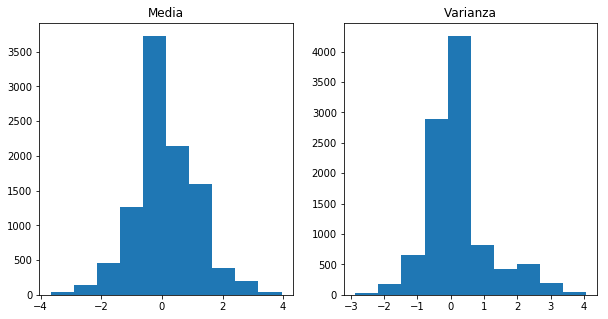

In [17]:
#Histogramas 
plt.figure(1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(x_test_encoded[:, 0])
plt.title('Media')
plt.subplot(1, 2, 2)
plt.hist(x_test_encoded[:, 1])
plt.title('Varianza')
plt.show()

* Los  histogramas muentran la distribución de las variables en el espacio latente, similar a una distribución normal.

### g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significada cada eje en la imagen ¿qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?

In [18]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator_2 = Model(decoder_input, _x_decoded_mean_squash)

In [19]:
##PLOT

def plt_grid(n,v1, v2, _generator):
    image_size = img_cols
    figure = np.zeros((image_size * n, image_size * n))
    #metodo de la transformada inversa
    grid_x = norm.ppf(np.linspace(v1, v2, n))
    grid_y = norm.ppf(np.linspace(v1, v2, n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])            
            x_decoded = _generator.predict(z_sample,batch_size=batch_size)
            figure[i * image_size: (i + 1) * image_size,
                j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
    plt.figure(figsize=(10, 10))
    plt.imshow(figure,cmap='gnuplot2')
    pos = np.arange(image_size/2,image_size*n,image_size)
    plt.yticks(pos,np.round(grid_y,1))
    plt.xticks(pos,np.round(grid_x,1))
    plt.show()

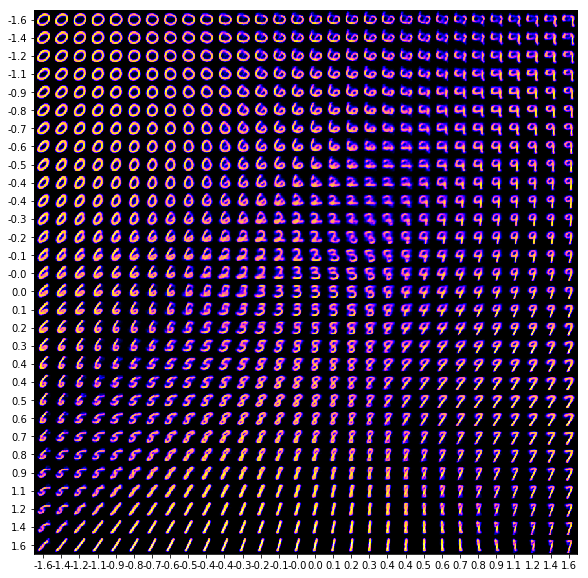

In [20]:
n = 30  # figure with 15x15 images 
v1 = 0.05
v2 = 0.95
plt_grid(n,v1, v2,generator_2)


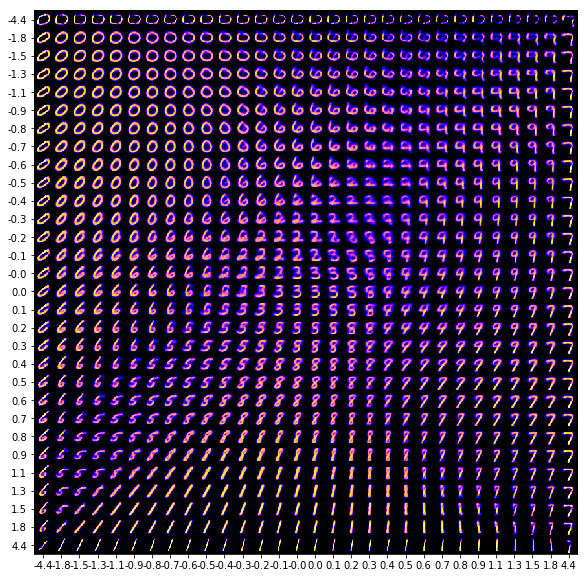

In [21]:
n = 30  # figure with 15x15 images 
#en los extremos del intervalo de confianza
v1 = 0.000005
v2 = 0.999995
plt_grid(n,v1, v2, generator_2)

** Comentarios ** 
* Ejes: eje *X* e *Y* son las dimensiones del espacio latente simuladodo alatoriamente (creadas artifialmente)  del generador.
* ¿qué sucede más allá en el espacio del 90% confianza de las variables latentes? Se obtienen imagenes más borrosas y con menos detalle.
* Se generan números que cuesta mucho más distinguir.

### h)  ¿Qué pasa al cambiar la distribución latente de los datos  $z$ ? Comente sobre alguna distribución elegida diferente a la Normal y muestre sobre el cómo debiera ser implementada.

* Si sólo se cambia la distribución latente de los datos, el  procedimiento del decoder va a seguir realizando un muestreo de  una distrbución normal multivariada, lo que ciertamente no coincidierá con otra distribución, por ejemplo uniforme.
* Si bien esto puede que no afecta la calidad de las imagenes generadas, si va a afectar la varibilidad de estas, ya que se tendrá un sesgo sobre cierta región del espacio latente. Por ejemplo si $z$ es uniforme cada imagen generada debería tener la misma probabilidad de parecerse a cualquiera de las imagenes originales, pero esto no sería así si se asume que la distribución es normal. 

### i) Comente sobre si mejora o empeora el desempeño al aumentar la dimensionalidad de las variables latentes $z$, explique.



In [22]:
history_dim4 = []
X_train, y_train, X_test, y_test, img_rows, img_cols , channel = loadData()
printFormatX(X_train, X_test)
printFormatY(X_train, X_test)
print("Reshape")
X_train, X_test = reshapeData(X_train, X_test)
printFormatX(X_train, X_test)

# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 4
intermediate_dim = 128

## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
#vae.summary()

# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

batch_size = 256
#epochs =  [10,15]
vae.compile(optimizer='rmsprop')
start_time = time.time()
history_dim4.append(vae.fit(X_train,epochs=10, batch_size=batch_size,validation_data=(X_test, None)))
end_time = time.time()
time_dim4 = end_time - start_time
print("Time ", time_dim4)

(28, 28)
X Train  (60000, 28, 28)
X Test (10000, 28, 28)
Y Train  (60000, 28, 28)
Y Test (10000, 28, 28)
Reshape
X Train  (60000, 28, 28, 1)
X Test (10000, 28, 28, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14

In [23]:
def graficarError(datos, etiquetas):
    ## Graficar el error, con el objetivo de visualiar de forma gráfica sus valores.
    _ = plt.close('all')
    _ = plt.title('Loss vs Epoch ')
    for d in datos:
        _ = plt.plot(d)
        _ = plt.xlabel('epoch')
        _ = plt.ylabel('loss')
    _ = plt.legend(etiquetas, loc='upper right')
    plt.show()

In [24]:
datos = []
#datos = map(lambda h: h,history)
datos.append(history_dim2[0].history['loss'])
datos.append(history_dim4[0].history['loss'])

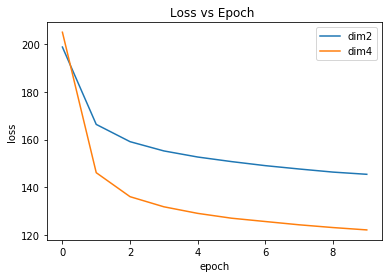

In [25]:
graficarError(datos,("dim2", "dim4"))

**Comentarios**

* Se prueba aumentar la dimensionalidad a 4, y con respecto al tiempo se obtiene una diferencia de 10 seg aprox
(obs. durante el desarrollo se ejecuto en distintas oportunidades, y en ocasiones el tiempo fue muy similar)
* Con respecto al valor de Loss, se observa que con dim=4 se obtienen mejores resultados.

In [26]:
print("Modelo dim  = 2: ", time_e)
print("Modelo dim  = 4: ", time_dim4)

Modelo dim  = 2:  63.22965693473816
Modelo dim  = 4:  58.96484112739563


In [27]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator_4 = Model(decoder_input, _x_decoded_mean_squash)

4


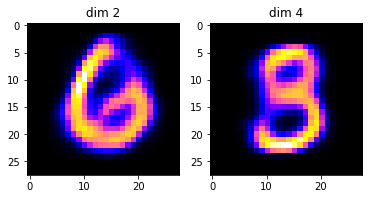

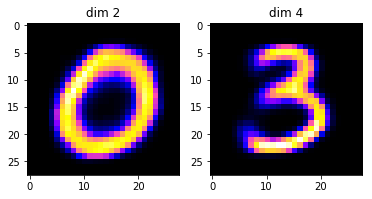

In [28]:
print(latent_dim)
#image_size = img_cols
#figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
#x = norm.ppf(np.linspace(0.01, 0.99, n))
#y = norm.ppf(np.linspace(v1, v2, n))

x10s = [norm.ppf(np.linspace(0.01, 0.99, n))]  * 4

## Ejemplo de imagen
z_sample = np.array([[x10s[0][10],x10s[1][10]]])         
x_decoded = generator_2.predict(z_sample,batch_size=batch_size)
plt.subplot(1, 2, 1)
plt.imshow(x_decoded[0][:,:,0],cmap='gnuplot2')
plt.title("dim 2")
z_sample = np.array([[x10s[0][10],x10s[1][10], x10s[2][10], x10s[3][10]]])         
x_decoded = generator_4.predict(z_sample,batch_size=batch_size)
plt.subplot(1, 2, 2)
plt.imshow(x_decoded[0][:,:,0],cmap='gnuplot2')
plt.title("dim 4")
plt.show()

## Ejemplo de imagen

z_sample = np.array([[x10s[0][5],x10s[1][5]]])         
x_decoded = generator_2.predict(z_sample,batch_size=batch_size)
plt.subplot(1, 2, 1)
plt.imshow(x_decoded[0][:,:,0],cmap='gnuplot2')
plt.title("dim 2")
z_sample = np.array([[x10s[0][5],x10s[1][5], x10s[2][5], x10s[3][5]]])         
x_decoded = generator_4.predict(z_sample,batch_size=batch_size)
plt.subplot(1, 2, 2)
plt.imshow(x_decoded[0][:,:,0],cmap='gnuplot2')
plt.title("dim 4")
plt.show()

** Comentario** Se observa que al aumentar el espacio a 4, lo números parecieran reconocerse mejor, sin embargo es muy subjetivo. Ya que son muys distitnos. Por lo que es díficil determinar de forma objetiva al mirar las imagenes si mejora o empeora.

### j) Vea qué sucede al cambiar algún aspectro estructural de la red (en su arquitectura). Recuerde que la estructura del *decoder* debe ser análoga a la del *encoder.

In [29]:
vae = None
history = []
X_train, y_train, X_test, y_test, img_rows, img_cols , channel = loadData()
printFormatX(X_train, X_test)
printFormatY(X_train, X_test)
print("Reshape")
X_train, X_test = reshapeData(X_train, X_test)
printFormatX(X_train, X_test)

# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 16
# convolution kernel size
num_conv = 4
latent_dim = 2
intermediate_dim = 128

## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu')(conv_2)
conv_4 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_3)

flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

## Decoder
shape_before_flattening = K.int_shape(conv_4)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',activation='relu')
decoder_deconv_3 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

batch_size = 256
#epochs =  [10,15]
vae.compile(optimizer='rmsprop')
start_time = time.time()
history.append(vae.fit(X_train,epochs=10, batch_size=batch_size,validation_data=(X_test, None)))
end_time = time.time()
time_dim = end_time - start_time
print("Time ", time_dim)

(28, 28)
X Train  (60000, 28, 28)
X Test (10000, 28, 28)
Y Train  (60000, 28, 28)
Y Test (10000, 28, 28)
Reshape
X Train  (60000, 28, 28, 1)
X Test (10000, 28, 28, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 16)   272         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 16)   4112        conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28

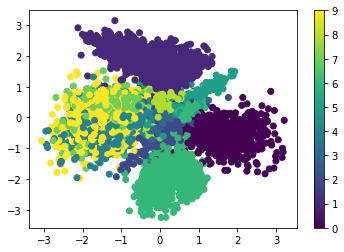

In [30]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)
#histogram

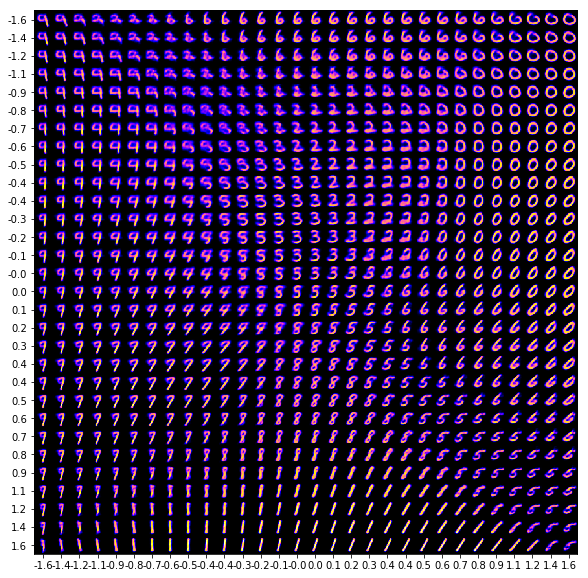

In [31]:
#decoder_input = Input(shape=(latent_dim,))
#_hid_decoded = decoder_hid(decoder_input)
#_up_decoded = decoder_upsample(_hid_decoded)
#_reshape_decoded = decoder_reshape(_up_decoded)
#_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
#_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
#_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
#generator_2 = Model(decoder_input, _x_decoded_mean_squash)


#GENERATOR
decoder_input = Input(shape=(latent_dim,))
hid_decoded = decoder_hid(decoder_input)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
generator = Model(decoder_input, x_decoded_mean_squash)

##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()


**Comentario:** 
* El cambio que se realizo fue agregar una capa convolucional, y se disminuyo el número del filtros a 16.
* Como se observa en la imagen, se obtienen resultados donde algunos números se distinguen de forma más clara, siendo otros muy difíciles de distinguir y reconocer.